In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/put-train-data/put_train
/kaggle/input/transformation/scikitlearn/default/1/scaler_x.pkl
/kaggle/input/transformation/scikitlearn/default/1/power_transformer_x.pkl
/kaggle/input/transform/scikitlearn/default/1/scaler_x.pkl
/kaggle/input/nk-iv-prediction/test_data.parquet
/kaggle/input/nk-iv-prediction/sample_submission.csv
/kaggle/input/nk-iv-prediction/train_data.parquet
/kaggle/input/cleaned-data/call_train1.parquet
/kaggle/input/call-test/calltest.parquet
/kaggle/input/train-data/call_train_data.parquet


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np


In [3]:
train = pd.read_parquet('/kaggle/input/train-data')

train.head(5)

train.shape

(4078811, 45)

In [7]:
X_remove = ['X0', 'X4', 'X5', 'X6', 'X7', 'X9', 'X11', 'X13', 'X15', 'X16', 'X20', 'X22', 'X23', 'X25', 'X28', 'X29', 'X30', 'X34', 'X38', 'X39', 'X41']

In [4]:
X_remove = ['X0', 'X4', 'X5', 'X6', 'X7', 'X9', 'X11', 'X13', 'X15', 'X16', 'X20', 'X22', 'X23', 'X25', 'X28', 'X29', 'X30', 'X34', 'X38', 'X39', 'X41']

train.drop(columns = X_remove, inplace = True)

train.shape

(4078811, 24)

In [52]:
from sklearn.model_selection import train_test_split

sampled_df = train.sample(frac=1, random_state=42)

X = sampled_df.drop('iv', axis=1) # Features

Y = sampled_df['iv']               # Target

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


x_train.shape,y_train.shape,x_test.shape,y_test.shape

NameError: name 'train' is not defined

In [6]:
standard_scale = StandardScaler()
x_train = standard_scale.fit_transform(x_train)
x_test = standard_scale.transform(x_test)

In [7]:
x_train.shape

(3263048, 23)

In [8]:
x_train.mean()

3.997374399014415e-16

In [9]:
print(x_train.mean())
x_test.mean()

3.997374399014415e-16


0.0003143721949817589

In [10]:
y_train.max() - y_train.min()

0.6393545

In [51]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

y_train_np = y_train_np.reshape(-1, 1).astype(np.float32)
y_test_np = y_test_np.reshape(-1, 1).astype(np.float32)

print(x_train_np.shape)
print(y_train_np.shape)

(112716, 23)
(112716, 1)


In [10]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow detected {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU detected by TensorFlow.")


TensorFlow detected 1 GPU(s):
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [21]:

from tensorflow.keras.optimizers import Adam
with tf.device('/GPU:0'):
    model = build_mlp_regressor(input_dim=x_train_np.shape[1])

    custom_lr = 0.001  # Example: set to your desired value
    optimizer = Adam(learning_rate=custom_lr)
    
    model.compile(optimizer= optimizer, loss='mse')
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        x_train_np, y_train_np,
        validation_data=(x_test_np, y_test_np),
        epochs=100,
        batch_size=500,
        callbacks = [early_stopping],
        verbose=1
    ) 

Epoch 1/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1912 - val_loss: 0.0079
Epoch 2/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 4/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 5/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 6/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 7/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 8/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 9/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 10/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 11/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 12

In [22]:
df_call.isna().sum()

x_input = df_call.drop(columns = ['iv']+ X_remove)


x_input = StandardScaler().fit_transform(x_input)
print(x_input.mean())
y_input = df_call['iv']



import numpy as np

# If not already NumPy arrays:
x_input = np.array(x_input)
y_input = np.array(y_input)

y_input = y_input.reshape(-1, 1)

predictions = model.predict(x_input)


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_input, predictions)
print("MSE on x_input:", mse)


9.44732996651897e-16
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
MSE on x_input: 0.002677533753016304


In [41]:
y_input.max() - y_input.min()

0.32889899999999994

In [35]:
df_call.isna().sum()

x_input = df_call.drop(columns = ['iv']+X_remove)
y_input = df_call['iv']


from sklearn.model_selection import train_test_split


X = x_input # Features

Y = y_input            # Target

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)


x_train.shape,y_train.shape,x_test.shape,y_test.shape

#scaler = MinMaxScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

y_train_np = y_train_np.reshape(-1, 1).astype(np.float32)
y_test_np = y_test_np.reshape(-1, 1).astype(np.float32)

print(x_train_np.shape)
print(y_train_np.shape)

(113071, 23)
(113071, 1)


In [43]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Convert y back to 1D for XGBoost
y_train_flat = y_train_np.ravel()
y_test_flat = y_test_np.ravel()

# Initialize and train the model
xgb_model = xgb.XGBRegressor(
    n_estimators=50,
    learning_rate=1,
    max_depth=10,
    subsample=1,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    tree_method='gpu_hist'      # 🚀 Enables GPU acceleration

)

xgb_model.fit(x_train_np, y_train_flat)

# Predict
y_pred = xgb_model.predict(x_test_np)

# Evaluation
mse = mean_squared_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)

print(f"XGBoost Test MSE: {mse:.6f}")



XGBoost Test MSE: 0.000087


In [28]:
import pickle

# Save the model
with open('call_xgb_model1.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU, ReLU
from tensorflow.keras.initializers import HeNormal


def build_mlp_regressor(input_dim, hidden_layers=[200,150,100], output_dim=1, dropout_rates=[0.2]):
    #assert len(hidden_layers) == len(dropout_rates), "Length of hidden_layers and dropout_rates must match"

    model = Sequential()
    initializer = HeNormal()

    # Input
    model.add(Input(shape=(input_dim,)))
    model.add(BatchNormalization())

    # Hidden layers
    for units, rate in zip(hidden_layers, dropout_rates):
        model.add(Dense(units, kernel_initializer=initializer))
        #model.add(BatchNormalization())
        model.add(ReLU())
        #model.add(Dropout(rate))  # 🔄 Apply each dropout rate per layer

    # Output layer
    model.add(Dense(output_dim, kernel_initializer=initializer))

    return model


In [60]:
from tensorflow.keras.callbacks import Callback

class LossPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        train_loss = logs.get("loss")
        print(f"Epoch {epoch+1:>3} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

from tensorflow.keras.optimizers import Adam
with tf.device('/GPU:0'):
    model = build_mlp_regressor(input_dim=x_train_np.shape[1])

    custom_lr = 0.001  # Example: set to your desired value
    optimizer = Adam(learning_rate=custom_lr)
    
    model.compile(optimizer= optimizer, loss='mse')
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, min_delta=1e-6, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        x_train_np, y_train_np,
        validation_data=(x_test_np, y_test_np),
        epochs=100,
        batch_size=200,
        callbacks = [early_stopping,LossPrinter()],
        verbose=0
    ) 

Epoch   1 | Train Loss: 0.831341 | Val Loss: 0.009167
Epoch   2 | Train Loss: 0.005970 | Val Loss: 0.004069
Epoch   3 | Train Loss: 0.003337 | Val Loss: 0.002680
Epoch   4 | Train Loss: 0.002344 | Val Loss: 0.001938
Epoch   5 | Train Loss: 0.001762 | Val Loss: 0.001494
Epoch   6 | Train Loss: 0.001394 | Val Loss: 0.001203
Epoch   7 | Train Loss: 0.001161 | Val Loss: 0.000988
Epoch   8 | Train Loss: 0.001006 | Val Loss: 0.001096
Epoch   9 | Train Loss: 0.000918 | Val Loss: 0.000816
Epoch  10 | Train Loss: 0.000870 | Val Loss: 0.000802
Epoch  11 | Train Loss: 0.000840 | Val Loss: 0.000838
Epoch  12 | Train Loss: 0.000814 | Val Loss: 0.000720
Epoch  13 | Train Loss: 0.000812 | Val Loss: 0.000822
Epoch  14 | Train Loss: 0.000795 | Val Loss: 0.001059
Epoch  15 | Train Loss: 0.000789 | Val Loss: 0.000694
Epoch  16 | Train Loss: 0.000758 | Val Loss: 0.000709
Epoch  17 | Train Loss: 0.000771 | Val Loss: 0.000799
Epoch  18 | Train Loss: 0.000745 | Val Loss: 0.000933
Epoch  19 | Train Loss: 0.00

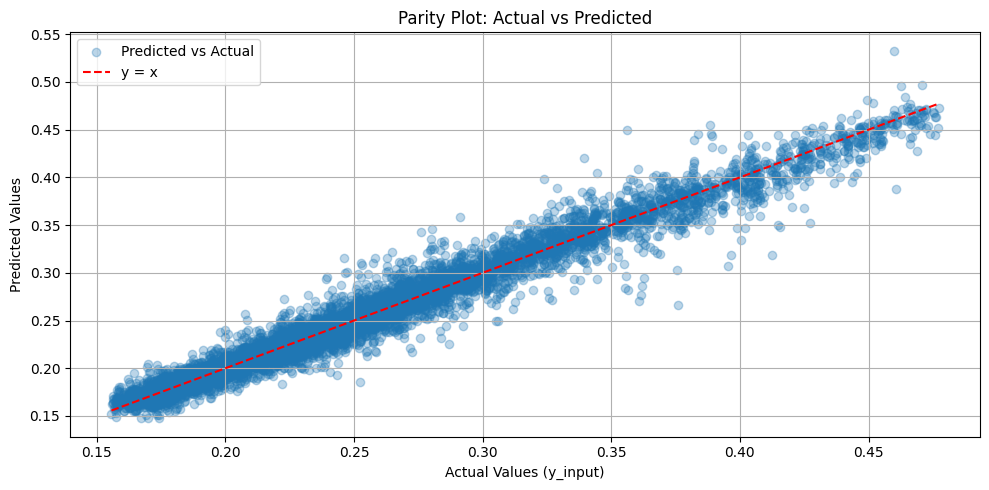

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten in case they are shaped (n, 1)
y_input = y_test_np 
predictions = y_pred

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_input, predictions, alpha=0.3, label='Predicted vs Actual')
plt.plot([y_input.min(), y_input.max()], [y_input.min(), y_input.max()], 'r--', label='y = x')
plt.xlabel('Actual Values (y_input)')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
model.save("/kaggle/working/call_mlp_model8.h5")

NameError: name 'model' is not defined

In [17]:
test = pd.read_parquet('/kaggle/input/nk-iv-prediction/test_data.parquet')
test.head(5)

test.drop(columns = ['timestamp'],  inplace = True)
test.head()

call = []
for col in test.columns.tolist() :
    if 'call' in col:
        call.append(col)
    else:
        continue
len(call)

put = []
for col in test.columns.tolist() :
    if 'put' in col:
        put.append(col)
    else:
        continue
len(put)  

k_call = []
for col in call:
    col.split('iv')[1]
    k_call.append(col.split('iv')[1].split('_')[1])
len(k_call)

call_test = test.drop(columns = put)
call_test.shape


all_values = []
modified = call_test[call]
for i in range(len(modified)):
    value = modified.iloc[i].tolist()  # 26 values
    all_values.extend(value)
len(all_values)

base_call = call_test.drop(columns = call)
base_call.shape

repeated_indices = np.repeat(base_call.index.values, 26)
expanded_col_call = base_call.loc[repeated_indices].reset_index(drop=True)

expanded_col_call['k'] = k_call * len(base_call)

expanded_col_call.shape

expanded_col_call['iv'] = all_values

expanded_col_call.head(27)

expanded_col_call['k'] = expanded_col_call['k'].astype(float)

import numpy as np

# Replace None with np.nan
expanded_col_call['iv'] = expanded_col_call['iv'].replace({'None': np.nan})

not_nan_rows = expanded_col_call[expanded_col_call['iv'].notna()]
not_nan_rows.head(10)
df_call = not_nan_rows
nan_rows = expanded_col_call[expanded_col_call['iv'].isna()]
new_df_call = nan_rows
new_df_call.head(10)
print(new_df_call.shape)
df_call.shape


df_call.isna().sum()


(188055, 45)


underlying    0
X0            0
X1            0
X2            0
X3            0
X4            0
X5            0
X6            0
X7            0
X8            0
X9            0
X10           0
X11           0
X12           0
X13           0
X14           0
X15           0
X16           0
X17           0
X18           0
X19           0
X20           0
X21           0
X22           0
X23           0
X24           0
X25           0
X26           0
X27           0
X28           0
X29           0
X30           0
X31           0
X32           0
X33           0
X34           0
X35           0
X36           0
X37           0
X38           0
X39           0
X40           0
X41           0
k             0
iv            0
dtype: int64

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU, ReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Activation

def build_mlp_regressor_put(input_dim, hidden_layers=[100,50,20], output_dim=1, dropout_rates=[0.4,0.1]):
    #assert len(hidden_layers) == len(dropout_rates), "Length of hidden_layers and dropout_rates must match"

    model1 = Sequential()
    initializer = HeNormal()

    # Input
    model1.add(Input(shape=(input_dim,)))
    model1.add(BatchNormalization())

    # Hidden layers
    for units, rate in zip(hidden_layers, dropout_rates):
        model1.add(Dense(units, kernel_initializer=initializer))
        #model1.add(BatchNormalization())
        model1.add(ReLU())

        
        #model1.add(Dropout(rate))  # 🔄 Apply each dropout rate per layer

    # Output layer
    model1.add(Dense(output_dim, kernel_initializer=initializer))

    return model1


In [62]:
from tensorflow.keras.callbacks import Callback

class LossPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        train_loss = logs.get("loss")
        print(f"Epoch {epoch+1:>3} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

from tensorflow.keras.optimizers import Adam
with tf.device('/GPU:0'):
    model = build_mlp_regressor(input_dim=x_train_np.shape[1])

    custom_lr = 0.001  # Example: set to your desired value
    optimizer = Adam(learning_rate=custom_lr)
    
    model.compile(optimizer= optimizer, loss='mse')
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-6, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        x_train_np, y_train_np,
        validation_data=(x_test_np, y_test_np),
        epochs=100,
        batch_size=200,
        callbacks = [early_stopping,LossPrinter()],
        verbose=0
    ) 

Epoch   1 | Train Loss: 0.756588 | Val Loss: 0.010649
Epoch   2 | Train Loss: 0.007276 | Val Loss: 0.005507
Epoch   3 | Train Loss: 0.004407 | Val Loss: 0.003772
Epoch   4 | Train Loss: 0.003189 | Val Loss: 0.002755
Epoch   5 | Train Loss: 0.002427 | Val Loss: 0.002089
Epoch   6 | Train Loss: 0.001931 | Val Loss: 0.001710
Epoch   7 | Train Loss: 0.001616 | Val Loss: 0.001400
Epoch   8 | Train Loss: 0.001396 | Val Loss: 0.001599
Epoch   9 | Train Loss: 0.001267 | Val Loss: 0.001348
Epoch  10 | Train Loss: 0.001187 | Val Loss: 0.001121
Epoch  11 | Train Loss: 0.001152 | Val Loss: 0.001458
Epoch  12 | Train Loss: 0.001111 | Val Loss: 0.000960
Epoch  13 | Train Loss: 0.001085 | Val Loss: 0.001248
Epoch  14 | Train Loss: 0.001049 | Val Loss: 0.001196
Epoch  15 | Train Loss: 0.001060 | Val Loss: 0.000921
Epoch  16 | Train Loss: 0.001022 | Val Loss: 0.000901
Epoch  17 | Train Loss: 0.001018 | Val Loss: 0.000913
Epoch  18 | Train Loss: 0.001021 | Val Loss: 0.000984
Epoch  19 | Train Loss: 0.00

In [30]:


x_input = df.drop(columns = ['iv']+ X_remove)
y_input = df['iv']


from sklearn.model_selection import train_test_split


X = x_input # Features

Y = y_input            # Target

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)


x_train.shape,y_train.shape,x_test.shape,y_test.shape

#standard_scale = StandardScaler()
#x_train = standard_scale.fit_transform(x_train)
#x_test = standard_scale.transform(x_test)

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

y_train_np = y_train_np.reshape(-1, 1).astype(np.float32)
y_test_np = y_test_np.reshape(-1, 1).astype(np.float32)

print(x_train_np.shape)
print(y_train_np.shape)

(112716, 23)
(112716, 1)


In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Convert y back to 1D for XGBoost
y_train_flat = y_train_np.ravel()
y_test_flat = y_test_np.ravel()

# Initialize and train the model
xgb_model_put = xgb.XGBRegressor(
    n_estimators= 50,
    learning_rate=1,
    max_depth=10,
    subsample=1,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    tree_method='gpu_hist'      # 🚀 Enables GPU acceleration

)

xgb_model_put.fit(x_train_np, y_train_flat)

# Predict
y_pred = xgb_model_put.predict(x_test_np)

# Evaluation
mse = mean_squared_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)

print(f"XGBoost Test MSE: {mse:.6f}")



XGBoost Test MSE: 0.000132


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten in case they are shaped (n, 1)
y_input = y_input
predictions = predictions

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_input, predictions, alpha=0.3, label='Predicted vs Actual')
plt.plot([y_input.min(), y_input.max()], [y_input.min(), y_input.max()], 'r--', label='y = x')
plt.xlabel('Actual Values (y_input)')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'y_input' is not defined

In [34]:
import pickle

# Save the model
with open('put_xgb_model1.pkl', 'wb') as f:
    pickle.dump(xgb_model_put, f)


In [63]:
model1.save("/kaggle/working/put_mlp_model4.h5")

In [29]:

test = pd.read_parquet('/kaggle/input/nk-iv-prediction/test_data.parquet')
test.drop(columns = ['timestamp'],  inplace = True)
test.head()

put_test = test.drop(columns = call)
put_test.shape


all_values_put = []
modified = put_test[put]
for i in range(len(modified)):
    value = modified.iloc[i].tolist()  # 26 values
    all_values_put.extend(value)
len(all_values_put)

base_put = put_test.drop(columns = put)
base_put.shape

repeated_indices = np.repeat(base_put.index.values, 26)
expanded_col_put = base_put.loc[repeated_indices].reset_index(drop=True)

k_put = []
for col in put:
    col.split('iv')[1]
    k_put.append(col.split('iv')[1].split('_')[1])
len(k_put)

expanded_col_put['k'] = k_put * len(base_put)

expanded_col_put.shape

expanded_col_put['iv'] = all_values_put

expanded_col_put['k'] = expanded_col_put['k'].astype(float)

import numpy as np

# Replace None with np.nan
expanded_col_put['iv'] = expanded_col_put['iv'].replace({'None': np.nan})

not_nan_rows = expanded_col_put[expanded_col_put['iv'].notna()]
not_nan_rows.head(10)
df = not_nan_rows
nan_rows = expanded_col_put[expanded_col_put['iv'].isna()]
new_df = nan_rows
new_df.head(10)
print(new_df.shape)
df.shape

(188449, 45)


(125241, 45)